# Changes in Biodiversity Intactness Index influenced by Urban Expansion in The Phoenix Metropolitan Area Over Time

Author: Ixel M. 

GitHub repository: https://github.com/IIDonaji/urban-sprawl-biodiversity-phoenix  

## Purpose: 

In 2021, Maricopa County, which includes the Phoenix metropolitan area, had the largest increase in developed land of any US county since 2001. This kind of urban expansion puts stress on biodiversity and natural habitats.

In this notebook, I will examine a dataset containing Biodiversity Intactness Index (BII) values to analyze changes in BII around the Phoenix area between 2017 and 2020.

## Highlights: 

- Exploring, extracting collections and items from SpatioTemporal Asset Catalog (STAC) 
- Analysing STAC data
- Calculating percent area of the Phoenix subbdivision 
- Maping Results
- Interpreting findings

## About The Data:
- BII `data:io-biodiversity` collection, from the Microsoft Planetary Computer's STAC catalog. This dataset was generated by Impact Observatory, in collaboration with Vizzuality. It contains terrestrial biodiversity intactness data at 100m resolution.

Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 5 December 2025.

- United States Census Bureau, County Subdivision shapefiles for Arizona. County subdivision level census data from 2022.

United States Census Bureau. (2022). Arizona County Subdivision 2022 TIGER/Line Shapefiles. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Accessed 5 December 2025.

### References
[1]
Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Dec. 4, 2025]
[2]
F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

[3]
Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 5 December 2025.


# Import the following libraries and packages

In [1]:
# Import library using standard abberivations 

import os # for reproducible file paths
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # for custom legend


# geospatial tools
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

# planetary computer tools
from pystac_client import Client # to access STAC catalog
import planetary_computer # To sign items from the MPC STAC catalog

# for images and mapping
from IPython.display import Image # To nicely display images
import contextily as ctx #for adding basemaps

# Import Arizona Census Subdivision data
-  The data/ was downloaded into a folder in the same level as this notebook.
- Extract the Phoenix Subdivison Shapefile
- Clean column names, select Phoenix County, and check CRS.

In [2]:
# Display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

# Set file path to read in shapefile
arizona_fp = os.path.join('data','tl_2022_04_cousub','tl_2022_04_cousub.shp')
arizona = gpd.read_file(arizona_fp)

## Explore and Extract the Phoenix Subdivision Shapefile 

In [3]:
# Preliminary exploration
arizona.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


In [4]:
# Change column names to lower case
arizona.columns = arizona.columns.str.lower()

# Filter for Phoenix
phoenix = arizona[arizona.name == "Phoenix"]

print(phoenix.crs)

EPSG:4269


Phoenix CRS is WGS 84 (EPSG:4326), this may need to be changed for later analysis. Its important to check CRS match when working with other geospatial data for meaningful analysis.

# Geographic Context 
Map the Phoenix subdivision within Maricopa County. 
- Use a basemap from the [Contextily](https://contextily.readthedocs.io/en/latest/) package. The basemap function `add_basemap` can be modified by updating the `source` paramater. By defualt the [OpenStreeMapHOT](https://contextily.readthedocs.io/en/latest/intro_guide.html) style is used.

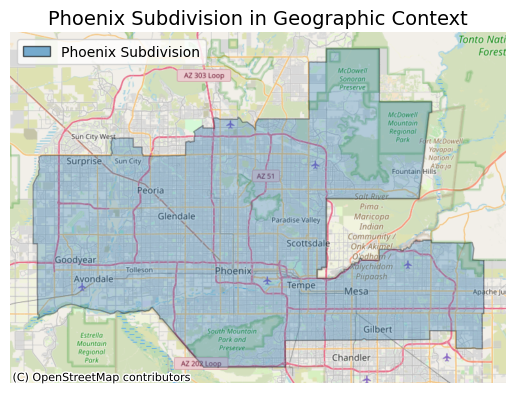

In [5]:
# Set up figure
fig, ax = plt.subplots()

# Create axis with plot
(phoenix.to_crs(epsg=3857) 
      .plot(ax=ax, figsize=(11, 10), alpha=0.30, edgecolor="black"))

# Add NatGeo basemap from contextily
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Update axes
ax.set_title("Phoenix Subdivision in Geographic Context", fontdict= {"fontsize": "14"})
ax.set_axis_off()

# Create patch for reference in legend
phoenix_outline = mpatches.Patch(edgecolor = "black", alpha = .6, label= "Phoenix Subdivision")
ax.legend(handles = [phoenix_outline], loc = "upper left")

# Saving map as an image for later use
plt.savefig('figures/phoenix_county.png', bbox_inches = "tight", dpi = 100)

# Extract BII Rasters from the Microsoft Planetary Computer Catalog
- To access the BII Time Series data we use the `Client` function from the `pystac_client` package to accessed raster directly from an online catalog database

In [6]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace, # `modifier` parameter is needed to access the data in the MPC catalog.
)

# Explore catalog matadata
print('Title:', catalog.title)
print('Description:', catalog.description)

# Pull out the io_biodiversity collection
bio_collection = catalog.get_child('io-biodiversity')

# Reduce outputs exploration with key metadata information
print("\nID:", bio_collection.id)
print("Title:", bio_collection.title)
print("Description:", bio_collection.description)
print("Extent:", bio_collection.extent)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer

ID: io-biodiversity
Title: Biodiversity Intactness
Description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spa

## Narrow down the catalog search

- Specifying time range, an area of interest, and the collection name.
    - Define area of interest using a `GeoJSON-type` dictionary with the following coordinates for the bouding box:
    
         `[-112.826843, 32.974108, -111.184387, 33.863574]`
    - Search the `io-biodiversity` collection.
    - Use the 2017 and 2020 rasters covering the Phoenix subdivision time range.

In [7]:
# Temporal range of interest (BII rasters 4-year window)
time_range = "2017-01-01/2017-12-31"

# Define bbox around Phoenix subdivision
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search for BII collection within bbox
search_2017 = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

search_2020 = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Retrieve first STAC item from search year result
items_2017 = list(search_2017.items())[0]
items_2020 = list(search_2020.items())[0]

Now that Items for 2017 and 2020 were identify use `assets.keys()` to view the avaliable assets and select the appropriate key as a reference to `open_rasterio` via the `rioxarray` accessor. After individually extracting rasters use `squeeze()` to drop the singular band so that each raster has the correct dimensions. 

In [8]:
# Determine reference term for assests
items_2017.assets.keys()

dict_keys(['data', 'tilejson', 'rendered_preview'])

In [9]:
# Individually open raster 
raster_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)
raster_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)

# Squeeze to remove length 1 dimension (band)
bii_2017 = raster_2017.squeeze().drop_vars('band')
bii_2020 = raster_2020.squeeze().drop_vars('band')

# Plot Biodiversity Intactness in the Phoenix subdivision
- Need to calculate percentage of the Phoenix subdivision area with a BII of at least 0.75 in 2017 and do the same for 2020.
    - Check raster (xarray) CRS match shapefile. 
    - Clip BII datas and Phoenix data to geometry of the Phoenix subdivision polygon.
    - Calculate percentage area
    - Check precent calculations over Phoenix area are not the complete rasters extents.
- Final visualization should show the area with BII >= 0.75 that was lost by 2020.

In [10]:
# Perform CRS's check with conditional statement
print(f" The Phoenix shapefile CRS is currently: {phoenix.crs.to_epsg()}")

if (phoenix.crs != bii_2017.rio.crs):
    phoenix = phoenix.to_crs(bii_2017.rio.crs)
    
print(f" The 2017 BII raster CRS is currently: {bii_2017.rio.crs.to_epsg()}")

print(f" The Phoenix shapefile CRS is now: {phoenix.crs.to_epsg()}")


 The Phoenix shapefile CRS is currently: 4269
 The 2017 BII raster CRS is currently: 4326
 The Phoenix shapefile CRS is now: 4326


In [11]:
# Clip small region to polygon
#phoenix_geom = list(phoenix.geometry)

# Clipping 2017 BII raster to the Phoenix polygon
phoenix_clip_2017 = bii_2017.rio.clip(phoenix.geometry, crs=phoenix.crs, drop=True)

# Performing this same step for the 2020 data:
phoenix_clip_2020 = bii_2020.rio.clip(phoenix.geometry, crs=phoenix.crs, drop=True)

In [12]:
# Create a masks to finds the values where for BII >= 0.75 
mask_2017 = phoenix_clip_2017 >= 0.75
mask_2020 = phoenix_clip_2020 >= 0.75

# Get only valid pixels in each year raster "~" refers to conditional
pixels_2017 = (~phoenix_clip_2017.isnull())
pixels_2020 = (~phoenix_clip_2020.isnull())

In [13]:
# Calculate percentage of area with BII >= 0.75
prt_2017 = (mask_2017.sum().item()
            / 
            pixels_2017.sum().item()) * 100

prt_2020 = (mask_2020.sum().item()
            / 
            pixels_2020.sum().item()) * 100

# viewing percentages:
pct_text = "The percentage of area in Phoenix County with a BII over 0.75 in"
print(f"{pct_text}, 2017 is: {prt_2017:.2}%")
print(f"\n{pct_text}, 2020 is: {prt_2020:.2}%")
change = prt_2020 - prt_2017
print(f"\nChange from 2017 to 2020: {change:.2f}%")

The percentage of area in Phoenix County with a BII over 0.75 in, 2017 is: 7.1%

The percentage of area in Phoenix County with a BII over 0.75 in, 2020 is: 7.1%

Change from 2017 to 2020: 0.00%


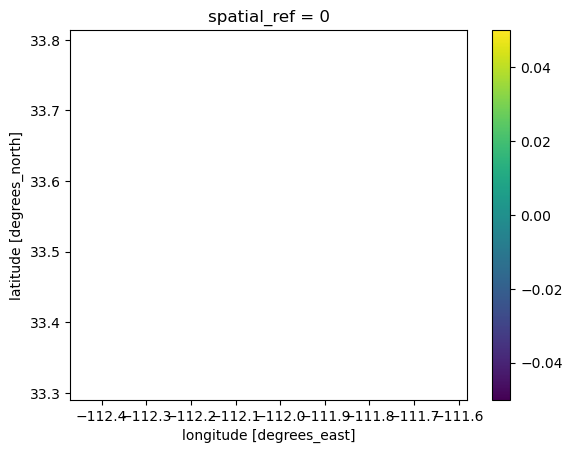

<xarray.DataArray (y: 583, x: 990)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0

In [18]:
# Create a difference mask to identify where status changed between two years
diff_mask = mask_2017 ^ mask_2020

# Include only changed pixels and set others to NaN
loss_numeric = diff_mask.where(diff_mask, other = np.nan)

# Plot loss areas to visualize where BII changed
fig, ax = plt.subplots()
loss_numeric.plot(ax =ax)
#plt.figure(figsize=(4,5))
plt.show()

loss_numeric

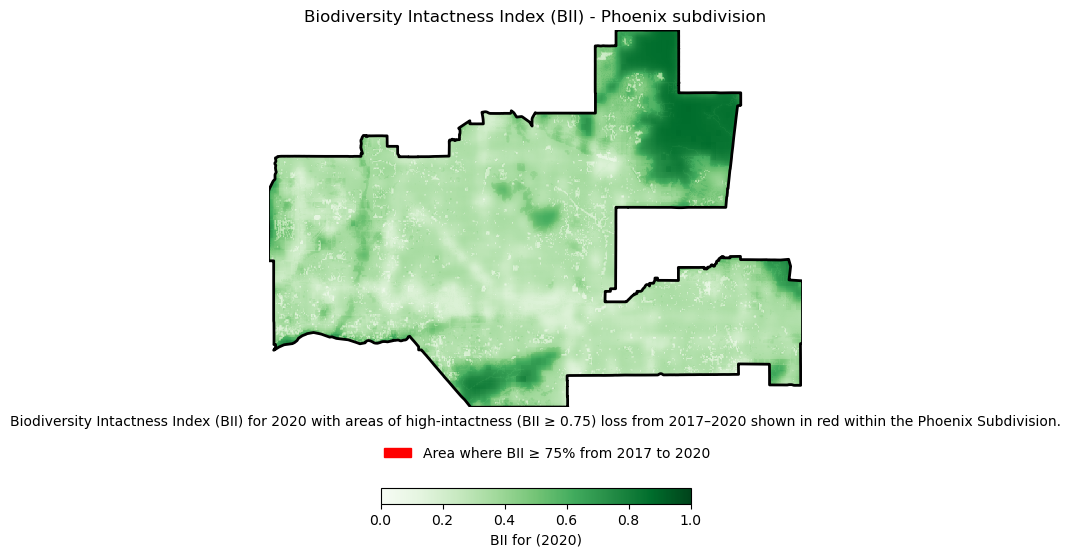

In [15]:
#  Calculate the BII loss
bii_loss = mask_2017 == 1 & (~mask_2020 == 0)

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 7))

# Remove axes for a cleaner plot
ax.axis("off")

# Plot 2020 BII 
phoenix_clip_2020.plot(ax=ax, 
                       cmap='Greens',
                       vmin=0, vmax=1, 
                       cbar_kwargs={'label': 'BII for (2020)', 
                                  'shrink': 0.5, 
                                  'orientation': 'horizontal',
                                  'pad': 0.15})

# Plot numerized area loss (NaN not included)
loss_numeric.plot(
                 ax=ax, # share axes
                  cmap = "Reds", # our predefined colormap object
                  add_colorbar = False # we're going to make a custom legend, so we don't want the default one
)

# Define legend for patch
loss_patch = mpatches.Patch(color = "red",
                                   label = "Area where BII ≥ 75% from 2017 to 2020")



# Phoenix polygon outline layer
phoenix.plot(ax = ax, # share axes (on the same plot as everything else)
             color = "none", # transparent fill, we just want the outline
             edgecolor = "black",
             linewidth = 2
            )


# Legend
# update legend, add in BII loss patch
ax.legend(handles = [loss_patch],
          frameon = False,
          bbox_to_anchor = (0.85, -0.07))

# Titles
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix subdivision")

# Set a caption with annotate()
ax.annotate("Biodiversity Intactness Index (BII) for 2020 with areas of high-intactness (BII ≥ 0.75) loss from 2017–2020 shown in red within the Phoenix Subdivision.",
            xy =(0.5, -0.05), # Position relative to axis (off from center, push up)
            xycoords ="axes fraction", # Recognize coordinate placement as fraction of axis size
            ha ="center", # Center
            fontsize = 10 # Font size
)

plt.show()

In the figure, there are noticeable losses of high-biodiversity (high-intactness) areas occurring mainly south of Phoenix and in the northeastern portion of Maricopa County. Approximately 7.13% of forested land in the county was classified as high-biodiversity in 2017, decreasing to 6.48% in 2020. This represents an estimated decline of 0.63% in high-intactness areas (BII ≥ 0.75) within the Phoenix subdivision (Maricopa County) over this period, as observed in Map 2. High-biodiversity loss was most obvious in forested regions, shown by the dark green areas in Map 1. As development expands in Maricopa County, forested areas should be monitored and protected to better assess and reduce impacts on biodiversity loss.